# Proyecto accidentes cerebrovasculares 
## Modelos lineales generalizados
### Autores:*Sebastian Caamaño*, *Cristobal Collao*, *América Suárez*
#### 15 noviembre 2021

In [1]:
library(tidyverse)
library(psych)
library(gridExtra)
library(GGally)
library(readxl)
library(Hmisc)
library(boot)
library(rsample)
library(pscl)
library(MASS)
#install.packages("effects")
library(effects)
library(mgcv)
library(lmtest)
#install.packages("Epi")
library(Epi)
#install.packages("mgcv")
library(mgcv)
library(tidyverse)
library(broom)

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.1     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

Warning message:
"package 'tibble' was built under R version 3.6.3"
Warning message:
"package 'tidyr' was built under R version 3.6.3"
Warning message:
"package 'readr' was built under R version 3.6.3"
Warning message:
"package 'purrr' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'forcats' was built under R version 3.6.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'psych'


The following objects are masked from 'package:ggplot2':

    %+%, alpha


Warning 

In [2]:
set.seed(030409)

## Presentación de los datos
La base de datos que se usa para el desarrollo de este proyecto son con respecto de distintas variables: 

    ° id-> Identificador.
    ° gender-> Género: Femenino(Female), Masculino(Male).
    ° age-> Edad del individuo.
    ° hypertension-> Hipertentensión: 0 si el individuo no presenta hipertensión, 1 si presenta hipertensión.
    ° heart_disease-> Enfermedad al corazón: 0 si no presenta enfermedad al corazón, 1 si presenta.
    ° ever_married-> Alguna vez casado: sí, no.
    ° work_type-> Tipo de trabajo: Niño(children), Trabajo de gobierno(Govt_jov), Nunca ha trabajado(Never_worked), Privado           (Private), Independiente (Self-employed).
    ° Residence_type-> Tipo de residencia: Rural, Urbana(Urban).
    ° avg_glucose_level-> Nivel medio de glucosa en la sangre.
    ° bmi-> Indice de masa coorporal
    ° smoking_status-> Estado fumador: anteriormente fumador(formerly smoked), nunca(never smoked), fuma(smokes),                     desconocido(unknown).
    ° stroke-> Accidente cerebrovascular: 1 el individuo presento un accidente cerebrovascular, 0 no se presento.
A lo largo de esta presentación se realizará un análisis descriptivo de la base de datos.

## Problema
En el contexto de la salud pública, los derrames cerebrales se presenta como la segunda causa de muerte responsable de aproximadamente un $11\%$ de las muertes en el mundo segun la Organizacion Mundial de la Salud (OMS). Frente a esto es necesario crear modelos para intentar prever la ocurrencia de estos. Para esto utilizaremos el dataset disponible con la finalidad de suministrar un modelo utilizable en la prevencion de los derrames cerebrales.

## Posible solución
Frente a esta problemática disponemos con un dataset con los que podremos diferenciar que factores se consideran de mayor riesgo y más determinantes en el riesgo de padecer un derrame cerebral. Nuestra variable de respuesta será la probabilidad de sufrir un derrame cerebral 

## Tipo de modelo a utilizar
El posible modelo que se utilizará en el conjunto de datos será el modelo logístico.

### Análisis descriptivo y visualización de los datos
*Se lee la data y a simple vista se observan N/A en la variable bmi*

In [3]:
df=read.csv("healthcare-dataset-stroke-data.csv")
head(df)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
,<int>,<fct>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<int>
1,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
3,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
4,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
5,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
6,56669,Male,81,0,0,Yes,Private,Urban,186.21,29,formerly smoked,1


In [4]:
1-sum(df$stroke)/(4861+249)

[1] 0.951272

In [5]:
1-(sum(df$stroke)/length(df$stroke))

[1] 0.951272

Calculamos el promedio de valores faltantes para observar si podemos hacer una imputacion de datos con el promedio de bmi, la imputacion se realizara si $sig\_na$ es menor al $2%$

In [6]:
valores_na=filter(df, bmi =='N/A')
sig_na=dim(valores_na)[1]/dim(df)[1]
sig_na

[1] 0.03933464

*Se observan las dimensiones de la data, en donde exiten $12$ columnas y $5110$ filas, es decir, $5110$ individuos participaron del estudio*

In [7]:
dim(df)

[1] 5110   12

*La variable id no aporta información por ende se elimina. Luego los N/A de la variable bmi se asignan como valores perdidos y se transfroman a numericos, para luego proceder a reemplazarlos. En la variable gender(género) se encuentra solo un individuo que se identifica como otro, por lo que se elimino, para más adelante transformar los datos a binarios.*

In [8]:
data = df[,-c(1)]
data$bmi = ifelse(data$bmi == 'N/A', NA, data$bmi)
data$bmi = as.numeric(data$bmi)

data = data[!(data$gender == 'Other'),]

*A continuación se cambiaron los 1 y 0 de algunas variables con su respectiva atribución para visualizar con mayor facilidad los datos*

In [9]:
data$stroke_t = ifelse(data$stroke == 1, 'stroke', 'no stroke') 
data$stroke_t = factor(data$stroke_t)

data$hypertension = ifelse(data$hypertension == 1, 'hypertension', 'no hypertension') 
data$hypertension = factor(data$hypertension)

data$heart_disease = ifelse(data$heart_disease == 1, 'heart disease', 'no heart disease') 
data$heart_disease = factor(data$heart_disease)

*Observamos la data con los cambios realizados*

In [10]:
data = data.frame(data)
data = filter(data,age >= 50)
dim(data)
head(data)

[1] 2210   12

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,stroke_t
,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<fct>
1,Male,67,no hypertension,heart disease,Yes,Private,Urban,228.69,240,formerly smoked,1,stroke
2,Female,61,no hypertension,no heart disease,Yes,Self-employed,Rural,202.21,NA,never smoked,1,stroke
3,Male,80,no hypertension,heart disease,Yes,Private,Rural,105.92,199,never smoked,1,stroke
4,Female,79,hypertension,no heart disease,Yes,Self-employed,Rural,174.12,114,never smoked,1,stroke
5,Male,81,no hypertension,no heart disease,Yes,Private,Urban,186.21,164,formerly smoked,1,stroke
6,Male,74,hypertension,heart disease,Yes,Private,Rural,70.09,148,never smoked,1,stroke


*A continuación en la variable bmi se omiten los NA, y se calcula el promedio y luego todos los NA los se reemplazan por el promedio obtenido $28.9$*

In [11]:
# eliminamos la imputacion original
# data$bmi[is.na(data$bmi)] <- round(mean(na.omit(data$bmi)),1)
head(data)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,stroke_t
,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<int>,<fct>
1,Male,67,no hypertension,heart disease,Yes,Private,Urban,228.69,240,formerly smoked,1,stroke
2,Female,61,no hypertension,no heart disease,Yes,Self-employed,Rural,202.21,NA,never smoked,1,stroke
3,Male,80,no hypertension,heart disease,Yes,Private,Rural,105.92,199,never smoked,1,stroke
4,Female,79,hypertension,no heart disease,Yes,Self-employed,Rural,174.12,114,never smoked,1,stroke
5,Male,81,no hypertension,no heart disease,Yes,Private,Urban,186.21,164,formerly smoked,1,stroke
6,Male,74,hypertension,heart disease,Yes,Private,Rural,70.09,148,never smoked,1,stroke


*Se realiza un resumen estadístico para cada variable. En las variables categóricas no se obtiene información relevante solo la cantidad total de individuos, como en genero, alguna vez casado, tipo de trabajo, tipo de residencia, estado fumador. Mientras que para las demás variables categoricas se obtiene el total por cada categoria. Para la edad se obtuvo un promedio de $43$ años, un mínimo de $0.08$ años que vendria siendo menos de un mes, y el máximo es de $82$ años. El nivel mínimo de glucosa en la sangre entre los individuos del estudio es de $55.12$, con una media $106.14$ y un máximo $271.47$. Para el índice de masa corporal se obtuvo un promedio de $28.89$, un máximo de $97.60$  y un mínimo $28.40$ y finalmente para los derrames cerebrales se obtiene una media de $0.048$ el cual no es significativo, ya que es una variable dicotomica, por ende solo existen unos y ceros.*

In [12]:
summary(data)

    gender          age                 hypertension           heart_disease 
 Female:1273   Min.   :50.00   hypertension   : 412   heart disease   : 261  
 Male  : 937   1st Qu.:56.00   no hypertension:1798   no heart disease:1949  
 Other :   0   Median :63.00                                                 
               Mean   :64.68                                                 
               3rd Qu.:74.00                                                 
               Max.   :82.00                                                 
                                                                             
 ever_married         work_type    Residence_type avg_glucose_level
 No : 172     children     :   0   Rural:1064     Min.   : 55.23   
 Yes:2038     Govt_job     : 361   Urban:1146     1st Qu.: 79.17   
              Never_worked :   0                  Median : 95.88   
              Private      :1242                  Mean   :118.44   
              Self-employed: 607    

*En el siguiente paso lo que se realizó fue por cada variable, contar la cantidad de individuos por atributo de esa variable(n), y por cada atributo cuanta cuantos accidentes cerebrovasculares estan presentes(derrames), y por otro lado tenemos el porcentaje el cual corresponde a el porcentaje de derrames en ese atributo, mejor dicho a la proporción de derrames presentes en ese atributo.* 

In [13]:
for (col_name in colnames(data[sapply(data, function(x) !(is.numeric(x)))])){
    output <- data %>%
        group_by(!!sym(col_name)) %>%
        summarise(
            porcentaje = round(mean(stroke), 3),
            n = n(),
            derrames = sum(stroke == 1)
        )
    View(output)
}

gender,porcentaje,n,derrames
<fct>,<dbl>,<int>,<int>
Female,0.100,1273,127
Male,0.109,937,102


hypertension,porcentaje,n,derrames
<fct>,<dbl>,<int>,<int>
hypertension,0.158,412,65
no hypertension,0.091,1798,164


heart_disease,porcentaje,n,derrames
<fct>,<dbl>,<int>,<int>
heart disease,0.180,261,47
no heart disease,0.093,1949,182


ever_married,porcentaje,n,derrames
<fct>,<dbl>,<int>,<int>
No,0.140,172,24
Yes,0.101,2038,205


work_type,porcentaje,n,derrames
<fct>,<dbl>,<int>,<int>
Govt_job,0.089,361,32
Private,0.109,1242,135
Self-employed,0.102,607,62


Residence_type,porcentaje,n,derrames
<fct>,<dbl>,<int>,<int>
Rural,0.099,1064,105
Urban,0.108,1146,124


smoking_status,porcentaje,n,derrames
<fct>,<dbl>,<int>,<int>
formerly smoked,0.114,580,66
never smoked,0.096,864,83
smokes,0.104,355,37
Unknown,0.105,411,43


stroke_t,porcentaje,n,derrames
<fct>,<dbl>,<int>,<int>
no stroke,0,1981,0
stroke,1,229,229


In [14]:
table(data$stroke)
1-191/1899


   0    1 
1981  229 

[1] 0.8994207

In [15]:
data=na.omit(data)

In [16]:
data %>%
    group_by(work_type, Residence_type) %>%
    summarise(
        n = n(), 
        porcentaje = round(mean(stroke), 3),
        derrames = sum(stroke)
    )

`summarise()` has grouped output by 'work_type'. You can override using the `.groups` argument.



work_type,Residence_type,n,porcentaje,derrames
<fct>,<fct>,<int>,<dbl>,<int>
Govt_job,Rural,162,0.080,13
Govt_job,Urban,182,0.077,14
Private,Rural,576,0.094,54
Private,Urban,600,0.100,60
Self-employed,Rural,276,0.091,25
Self-employed,Urban,294,0.085,25


*A continuación se presentan distintos gráficos. Podemos observar en el siguiente gráfico el histograma de la frecuencia de edad, se nota claramente un pick o más bien una mayor frecuencia por los 45 años aproximadamente.*

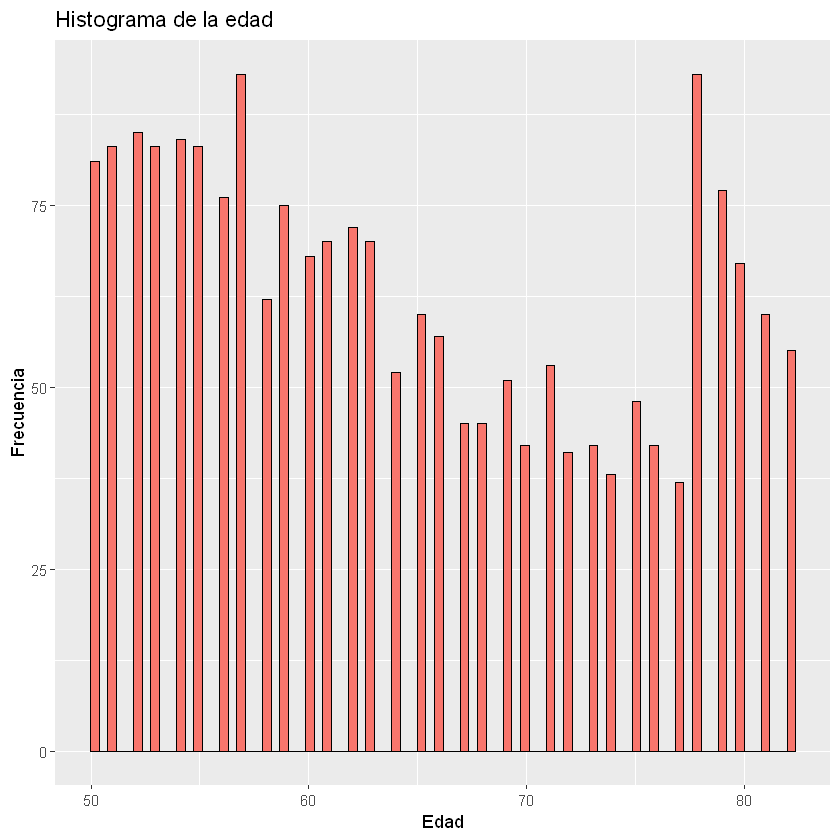

In [17]:
ggplot(data, aes(x = age)) + 
    geom_histogram(fill = '#F8766D', col = 'black',bins = max(data$age)) +   
labs(title = "Histograma de la edad",
       x="Edad",
       y="Frecuencia")

*A continuación se aprecia el histograma del índice de masa corpolar, donde se observa una pequeña cola a la derecha, es decir que pocas personas tienen un IMC alto.*

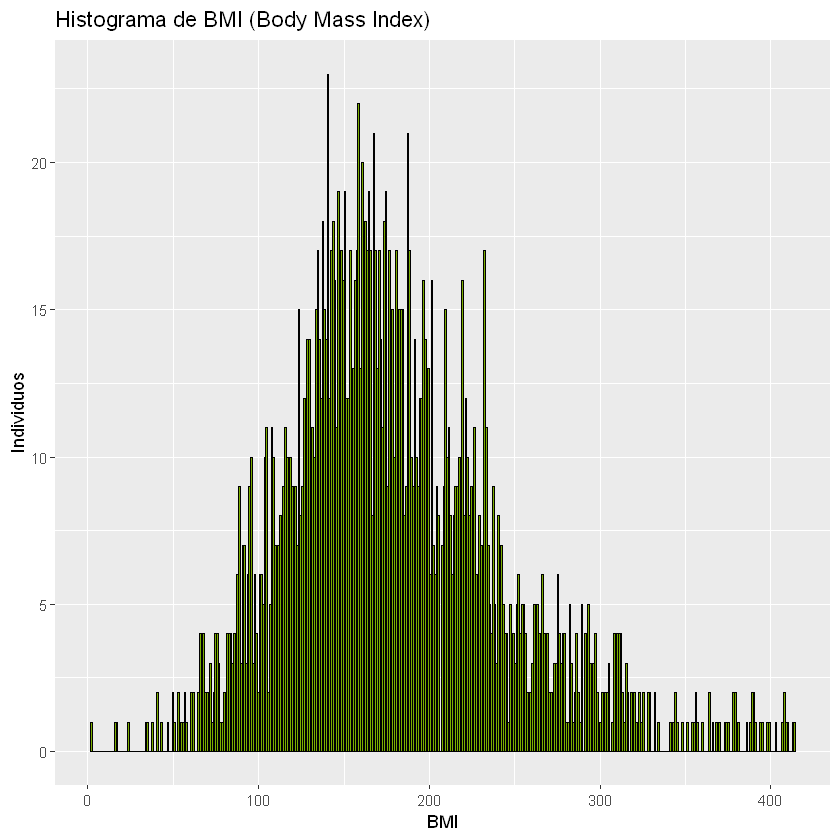

In [18]:
ggplot(data, aes(x = bmi)) + geom_histogram(fill = '#7CAE00', col = 'black',bins =  max(na.omit(data$bmi))) +
labs(title = "Histograma de BMI (Body Mass Index)",
       x="BMI",
       y="Individuos")

*Se observa el histograma de la frecuencia del promedio de glucosa.*

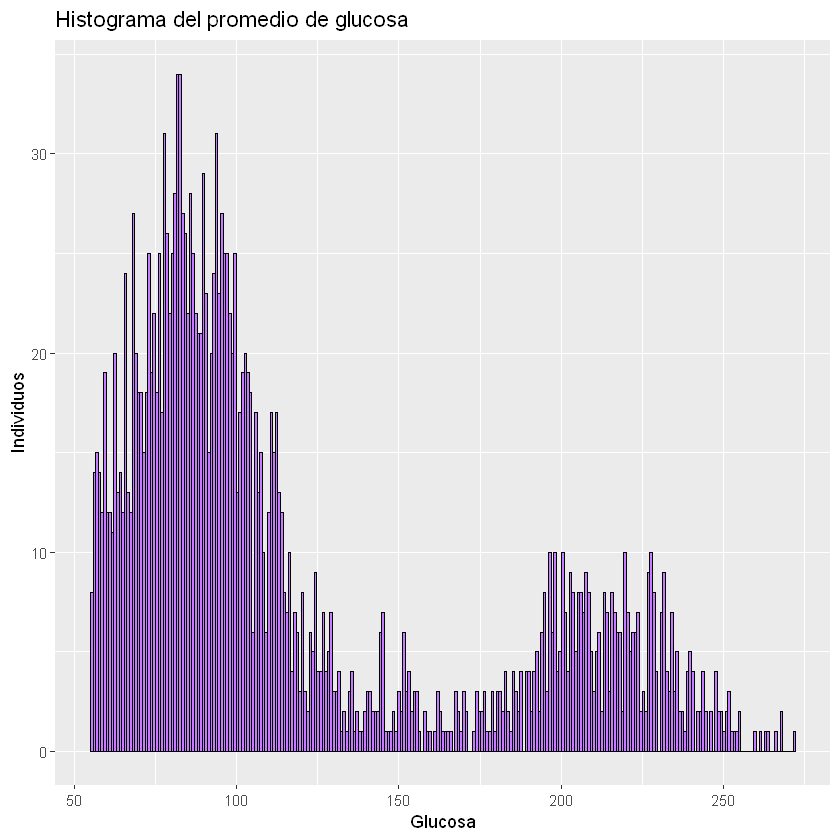

In [19]:
ggplot(data, aes(x = avg_glucose_level)) + geom_histogram(fill = '#C77CFF', col = 'black',bins = max(data$avg_glucose_level) ) +   
labs(title = "Histograma del promedio de glucosa",
       x="Glucosa",
       y="Individuos")

*A continuación podemos observar la densidad empirica de derrames según la edad, se aprecia una clara tendencia que a mayor edad mayor cantidad de derrames.*

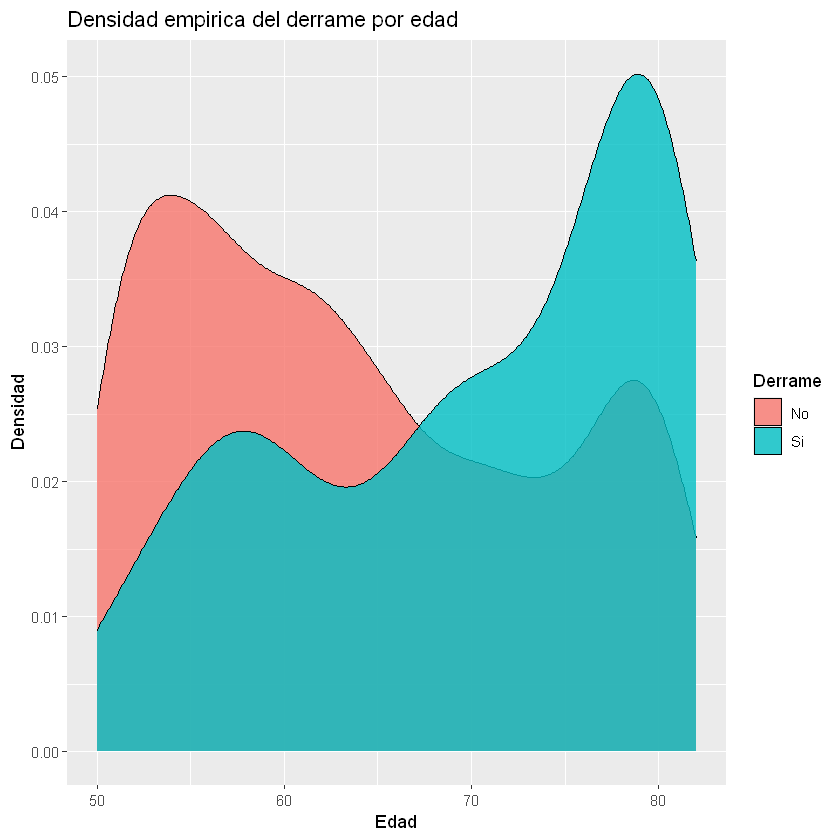

In [20]:
ggplot(data, aes(x = age, fill = stroke_t))+ geom_density(alpha = 0.8) + 
  labs(title = "Densidad empirica del derrame por edad",
       x="Edad",
       y="Densidad") + scale_fill_discrete(name = "Derrame", labels = c("No", "Si"))

*En el siguiente gráfico de barras se encuentra la cantidad de individuos por sexo, encontramos $2994$ mujeres y $2115$ hombres.*

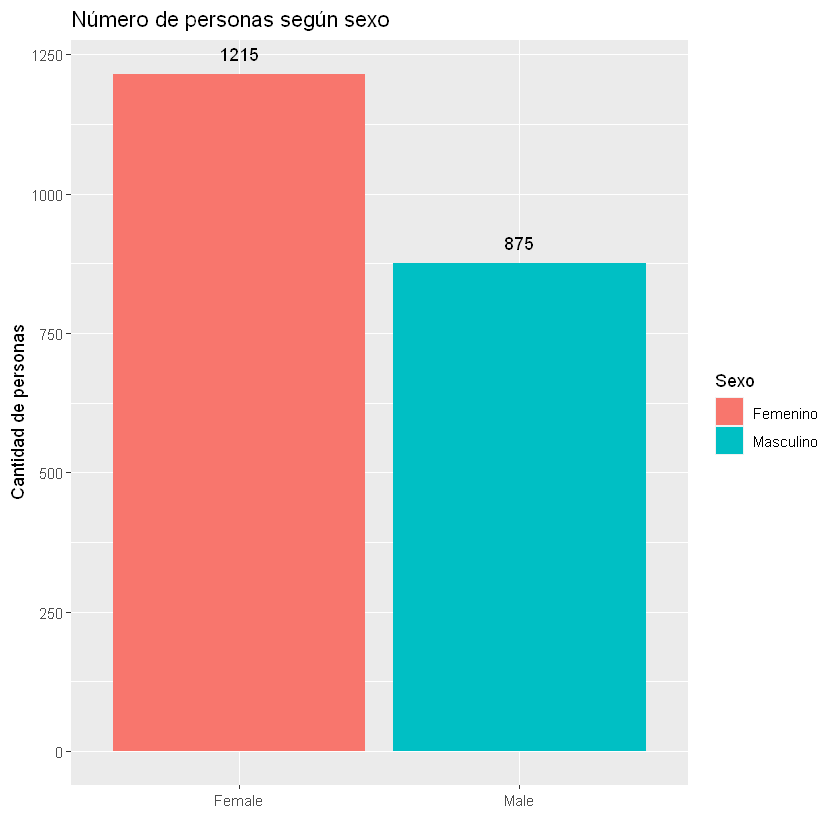

In [21]:
ggplot(data = data, aes(x=gender,fill=gender))+geom_bar()+
  labs(title = "Número de personas según sexo",
       x="",
       y="Cantidad de personas") + scale_fill_discrete(name = "Sexo", labels = c("Femenino", "Masculino")) + 
       geom_text(stat='count', aes(label=..count..), vjust=-1)

*La cantidad de personas que han estado casadas alguna vez se encuentra en el siguiente gráfico de barras y se aprecia que es de $3353$ y los que no han estado casados nunca es de $1756$*

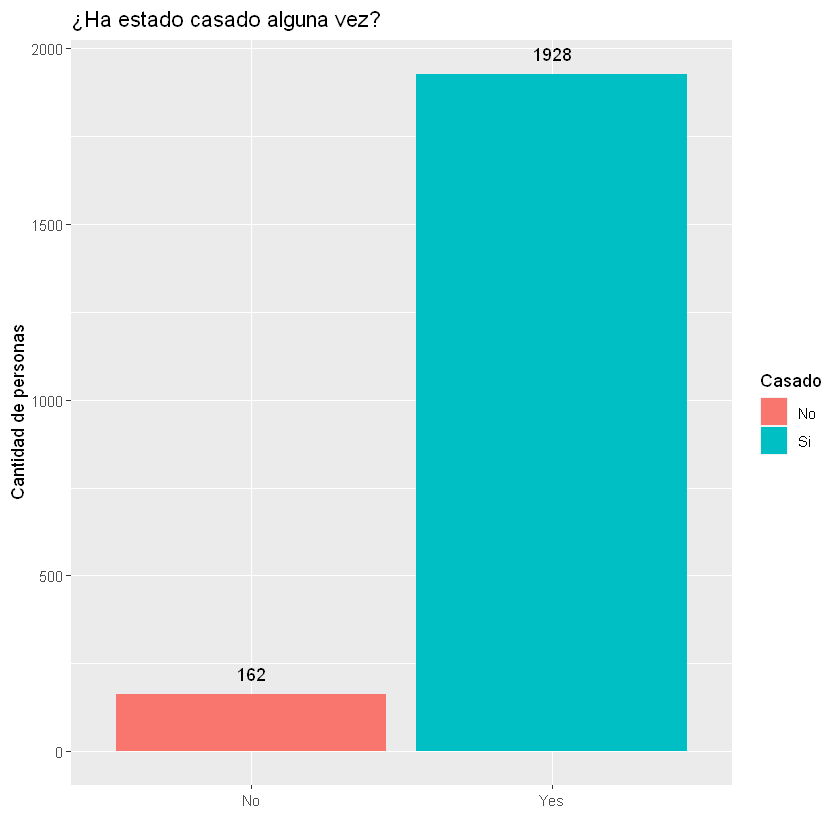

In [22]:
ggplot(data = data, aes(x=ever_married,fill=ever_married))+geom_bar() + 
  labs(title = "¿Ha estado casado alguna vez?",
       x="",
       y="Cantidad de personas") + scale_fill_discrete(name = "Casado", labels = c("No", "Si")) + 
       geom_text(stat='count', aes(label=..count..), vjust=-1)

*La cantidad de individuos del estudio que se encuentran en distintos trabajos lo podemos observar en el siguiente gráfico de barras. Podemos apreciar que existen $2924$ individuos que trabajan en alguna entidad privada, luego encontramos a $819$ personas independientes, los que poseen un trabajo de gobierno son $657$, se encuentra una cantidad de $687$ niños, y por último las personas del estudio que nunca han trabajado son $22$.*

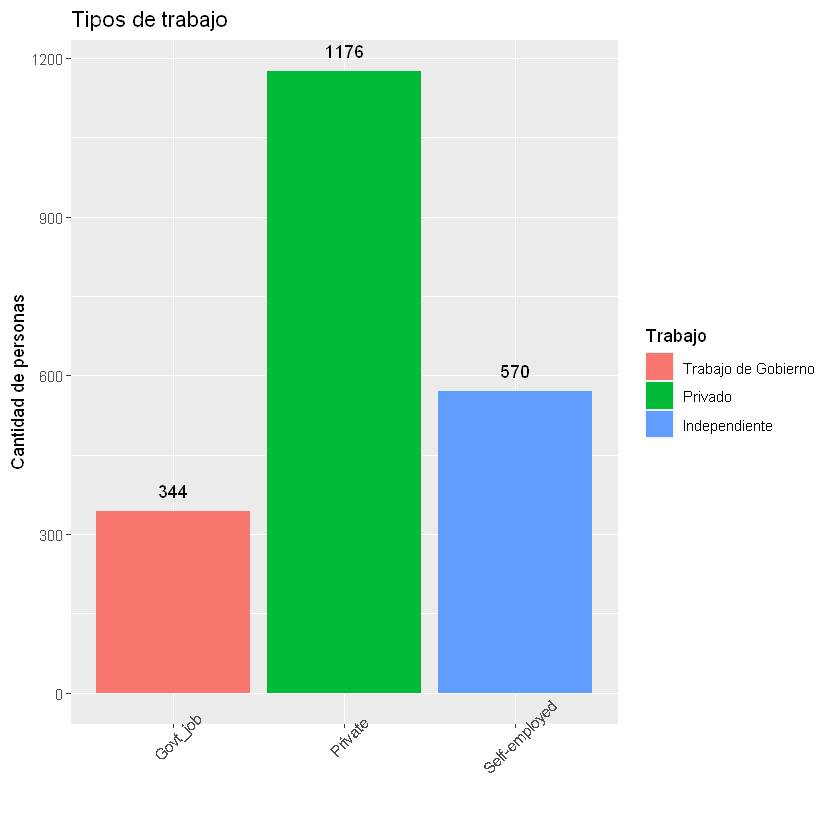

In [23]:
ggplot(data = data, aes(x=work_type,fill=work_type))+geom_bar()+theme(axis.text.x =element_text(angle = 45) ) +
scale_fill_discrete(name = "Trabajo", labels = c("Trabajo de Gobierno","Privado","Independiente")) +  labs(title = "Tipos de trabajo",
       x="",
       y="Cantidad de personas") + 
       geom_text(stat='count', aes(label=..count..), vjust=-1)

In [24]:
# Datos no nivelados 

data$gender <- as.factor(data$gender)
data$work_type <- as.factor(data$work_type)

data$hypertension <- as.factor(data$hypertension)
data$heart_disease <- as.factor(data$heart_disease)
data$ever_married <- as.factor(data$ever_married)
data$bmi <- as.numeric(data$bmi)
data$stroke<-factor(data$stroke)

In [25]:
stroke_original <- glm(stroke~ gender+age+hypertension+heart_disease+ever_married+avg_glucose_level+bmi,
data=data, family = binomial(link = "logit"))
summary(stroke_original)

exp(coef(stroke_original))  # Razones de ventajas ("odds ratios")


Call:
glm(formula = stroke ~ gender + age + hypertension + heart_disease + 
    ever_married + avg_glucose_level + bmi, family = binomial(link = "logit"), 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1651  -0.4757  -0.3423  -0.2641   2.7179  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -5.6341400  0.8143179  -6.919 4.55e-12 ***
genderMale                     0.0223346  0.1601867   0.139  0.88911    
age                            0.0557600  0.0085963   6.486 8.79e-11 ***
hypertensionno hypertension   -0.5519599  0.1762335  -3.132  0.00174 ** 
heart_diseaseno heart disease -0.4252601  0.2056769  -2.068  0.03868 *  
ever_marriedYes               -0.2213898  0.2676115  -0.827  0.40808    
avg_glucose_level              0.0051652  0.0013233   3.903 9.48e-05 ***
bmi                           -0.0004227  0.0013500  -0.313  0.75419    
---
Signif. codes:  0 '***' 0.001 '**' 0

(Intercept)                    genderMale 
                  0.003573749                   1.022585934 
                          age   hypertensionno hypertension 
                  1.057343898                   0.575820166 
heart_diseaseno heart disease               ever_marriedYes 
                  0.653599780                   0.801404235 
            avg_glucose_level                           bmi 
                  1.005178611                   0.999577388

In [26]:
model.zi = zeroinfl(ifelse(as.numeric(data$stroke)==1,0,1)~ gender+age+hypertension+heart_disease+
               ever_married+avg_glucose_level+bmi,data=data,
                    dist = "negbin")

                       ### dist = "negbin" may be used

summary(model.zi)
exp(coef(model.zi))  # Razones de ventajas ("odds ratios")

Warning message in sqrt(diag(vc)[np]):
"Se han producido NaNs"



Call:
zeroinfl(formula = ifelse(as.numeric(data$stroke) == 1, 0, 1) ~ gender + 
    age + hypertension + heart_disease + ever_married + avg_glucose_level + 
    bmi, data = data, dist = "negbin")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-0.8500 -0.3230 -0.2399 -0.1879  8.5441 

Count model coefficients (negbin with log link):
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -4.701309   0.846281  -5.555 2.77e-08 ***
genderMale                     0.020781   0.156856   0.132   0.8946    
age                            0.041693   0.009237   4.513 6.38e-06 ***
hypertensionno hypertension   -0.317968   0.171429  -1.855   0.0636 .  
heart_diseaseno heart disease -0.257480   0.197883  -1.301   0.1932    
ever_marriedYes               -0.365929   0.269089  -1.360   0.1739    
avg_glucose_level              0.006246   0.001448   4.314 1.60e-05 ***
bmi                           -0.002298   0.001470  -1.563   0.1180    
Log

count_(Intercept)                    count_genderMale 
                       9.083382e-03                        1.020998e+00 
                          count_age   count_hypertensionno hypertension 
                       1.042574e+00                        7.276259e-01 
count_heart_diseaseno heart disease               count_ever_marriedYes 
                       7.729972e-01                        6.935518e-01 
            count_avg_glucose_level                           count_bmi 
                       1.006266e+00                        9.977050e-01 
                   zero_(Intercept)                     zero_genderMale 
                       1.505291e+02                        3.097242e+00 
                           zero_age    zero_hypertensionno hypertension 
                       8.130039e-01                        1.221636e+04 
 zero_heart_diseaseno heart disease                zero_ever_marriedYes 
                       1.069787e+01                        1.949674e-02 
             zero_avg_glucose_level                            zero_bmi 
                       1.049081e+00                        9.381770e-01

In [27]:
blablablaa=glm.nb(ifelse(as.numeric(data$stroke)==1,0,1)~ gender+age+hypertension+heart_disease+
               ever_married+avg_glucose_level+bmi,data=data)
exp(coef(blablablaa))  # Razones de ventajas ("odds ratios")

Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"
Warning message in theta.ml(Y, mu, sum(w), w, limit = control$maxit, trace = control$trace > :
"iteration limit reached"


(Intercept)                    genderMale 
                  0.004381154                   1.018178021 
                          age   hypertensionno hypertension 
                  1.050781413                   0.629149766 
heart_diseaseno heart disease               ever_marriedYes 
                  0.707646521                   0.833295411 
            avg_glucose_level                           bmi 
                  1.004399735                   0.999695219

In [28]:
summary(blablablaa)


Call:
glm.nb(formula = ifelse(as.numeric(data$stroke) == 1, 0, 1) ~ 
    gender + age + hypertension + heart_disease + ever_married + 
        avg_glucose_level + bmi, data = data, init.theta = 1753.68888, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.1098  -0.4564  -0.3383  -0.2684   2.2935  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -5.4304432  0.7630194  -7.117  1.1e-12 ***
genderMale                     0.0180148  0.1482309   0.122  0.90327    
age                            0.0495341  0.0080710   6.137  8.4e-10 ***
hypertensionno hypertension   -0.4633859  0.1603781  -2.889  0.00386 ** 
heart_diseaseno heart disease -0.3458106  0.1847751  -1.872  0.06127 .  
ever_marriedYes               -0.1823671  0.2431671  -0.750  0.45328    
avg_glucose_level              0.0043901  0.0012115   3.624  0.00029 ***
bmi                           -0.0003048  0.0012578  -0.242  0.

   predicciones
       0    1
  0 1896    3
  1  189    2

[1] 0.908134

count_(Intercept)                    count_genderMale 
                       9.083382e-03                        1.020998e+00 
                          count_age   count_hypertensionno hypertension 
                       1.042574e+00                        7.276259e-01 
count_heart_diseaseno heart disease               count_ever_marriedYes 
                       7.729972e-01                        6.935518e-01 
            count_avg_glucose_level                           count_bmi 
                       1.006266e+00                        9.977050e-01 
                   zero_(Intercept)                     zero_genderMale 
                       1.505291e+02                        3.097242e+00 
                           zero_age    zero_hypertensionno hypertension 
                       8.130039e-01                        1.221636e+04 
 zero_heart_diseaseno heart disease                zero_ever_marriedYes 
                       1.069787e+01                        1.949674e-02 
             zero_avg_glucose_level                            zero_bmi 
                       1.049081e+00                        9.381770e-01

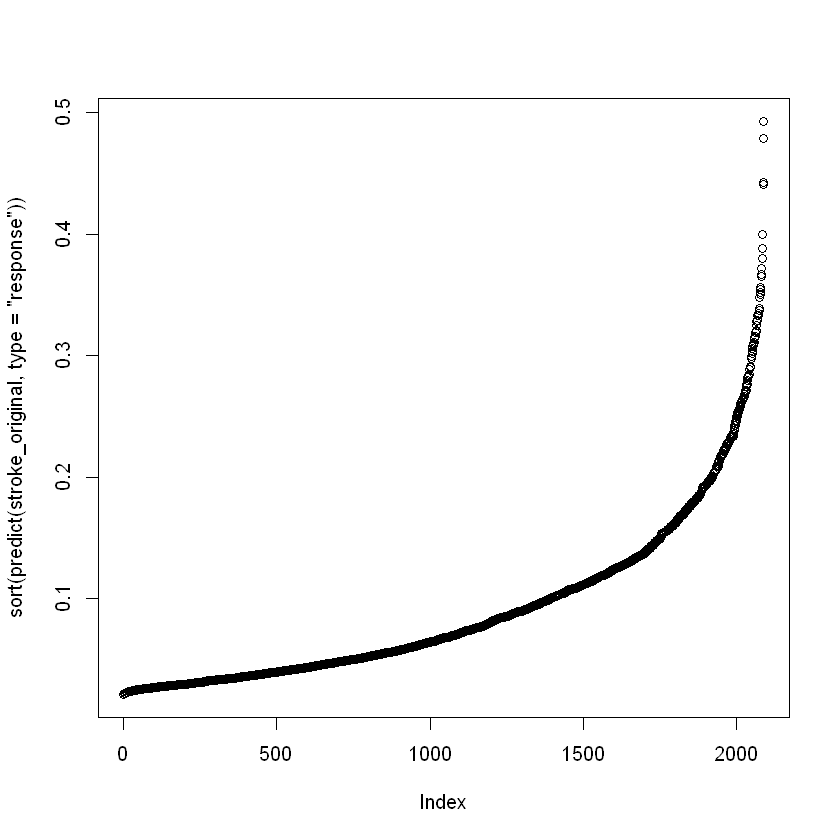

In [29]:
blablablaa=model.zi
predicciones <- ifelse(test = blablablaa$fitted.values > 0.5, yes = 1, no = 0)
matriz_confusion_original <- table(blablablaa$model[[1]], predicciones)

nivel_po = (matriz_confusion_original[1,1]+matriz_confusion_original[2,2])/sum(matriz_confusion_original)
matriz_confusion_original
nivel_po
plot(sort(predict(stroke_original,type = 'response')))
exp(coef(blablablaa))  # Razones de ventajas ("odds ratios")

             predicciones
observaciones    0    1
            0 1771  128
            1  150   41

[1] 0.8669856

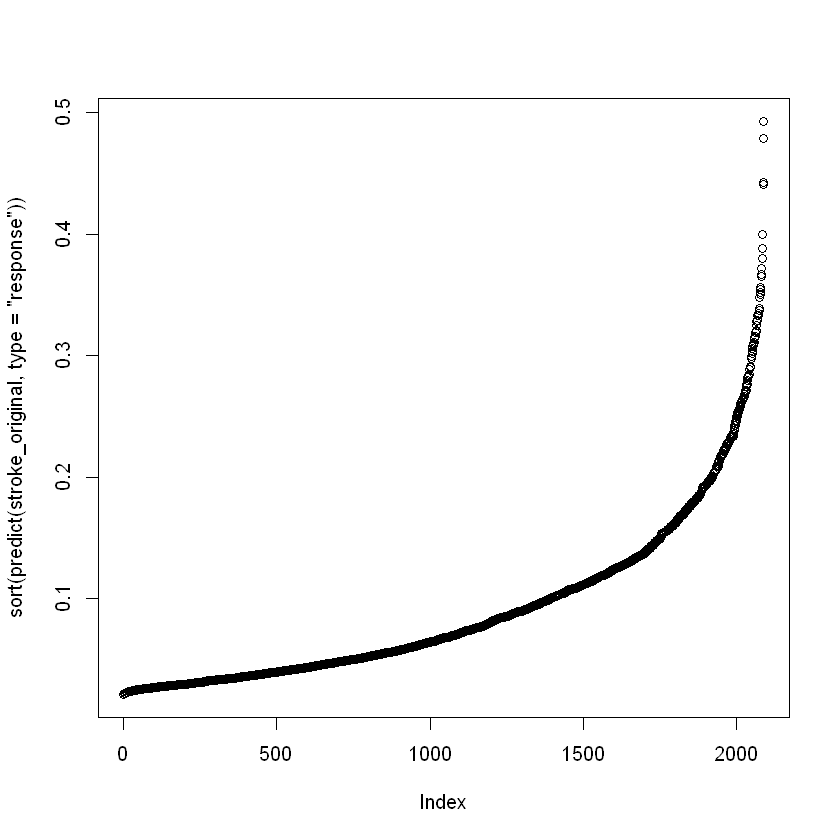

In [30]:
predicciones <- ifelse(test = stroke_original$fitted.values > 0.2, yes = 1, no = 0)
matriz_confusion_original <- table(stroke_original$model$stroke, predicciones,
                          dnn = c("observaciones", "predicciones"))
nivel_po = (matriz_confusion_original[1,1]+matriz_confusion_original[2,2])/sum(matriz_confusion_original)

matriz_confusion_original
nivel_po
plot(sort(predict(stroke_original,type = 'response')))

In [31]:
n=500
strokes_s=data %>% filter(stroke == 1)
ssy = sample_n(strokes_s, size = n,replace = TRUE)

strokes_n=data %>% filter(stroke == 0)
ssn = sample_n(strokes_n, size = n,replace = TRUE)

In [32]:
newdata = rbind(ssy,ssn)
newdata = data.frame(newdata)

In [33]:
head(newdata)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,stroke_t
,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,Male,56,hypertension,no heart disease,Yes,Private,Rural,249.31,232,never smoked,1,stroke
2,Male,69,no hypertension,no heart disease,Yes,Private,Rural,93.81,159,Unknown,1,stroke
3,Female,81,no hypertension,no heart disease,Yes,Self-employed,Urban,95.84,89,never smoked,1,stroke
4,Male,77,no hypertension,no heart disease,Yes,Self-employed,Rural,162.14,200,formerly smoked,1,stroke
5,Male,76,hypertension,no heart disease,Yes,Private,Rural,243.58,210,never smoked,1,stroke
6,Female,55,no hypertension,no heart disease,Yes,Self-employed,Rural,92.98,130,never smoked,1,stroke


In [34]:
stroke_balanceado_todo <- glm(stroke~gender+age+hypertension+heart_disease+ever_married+work_type+Residence_type+
                              avg_glucose_level+bmi+smoking_status,data=newdata, family = binomial(link = "logit"))
summary(stroke_balanceado_todo)
exp(coef(stroke_balanceado_todo))  # Razones de ventajas ("odds ratios")


Call:
glm(formula = stroke ~ gender + age + hypertension + heart_disease + 
    ever_married + work_type + Residence_type + avg_glucose_level + 
    bmi + smoking_status, family = binomial(link = "logit"), 
    data = newdata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4481  -0.9653  -0.0734   0.9715   2.0183  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -3.7980934  0.7924391  -4.793 1.64e-06 ***
genderMale                     0.0448683  0.1479913   0.303 0.761751    
age                            0.0686401  0.0081814   8.390  < 2e-16 ***
hypertensionno hypertension   -0.6129419  0.1724323  -3.555 0.000378 ***
heart_diseaseno heart disease -0.5987890  0.2217505  -2.700 0.006928 ** 
ever_marriedYes               -0.6124454  0.2787978  -2.197 0.028039 *  
work_typePrivate              -0.1059610  0.2142607  -0.495 0.620923    
work_typeSelf-employed        -0.2939836  0.2392927  -1.229

(Intercept)                    genderMale 
                   0.02241347                    1.04589012 
                          age   hypertensionno hypertension 
                   1.07105064                    0.54175471 
heart_diseaseno heart disease               ever_marriedYes 
                   0.54947667                    0.54202378 
             work_typePrivate        work_typeSelf-employed 
                   0.89945975                    0.74528875 
          Residence_typeUrban             avg_glucose_level 
                   0.78689078                    1.00789731 
                          bmi    smoking_statusnever smoked 
                   1.00032017                    0.76324218 
         smoking_statussmokes         smoking_statusUnknown 
                   1.23657209                    0.89098775

In [35]:
stroke_balanceado_1 <- glm(stroke~ age+hypertension+heart_disease+ever_married+avg_glucose_level,
data=newdata, family = binomial(link = "logit"))
summary(stroke_balanceado_1)
  # Razones de ventajas ("odds ratios")


Call:
glm(formula = stroke ~ age + hypertension + heart_disease + ever_married + 
    avg_glucose_level, family = binomial(link = "logit"), data = newdata)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.30030  -0.95831  -0.09314   0.98180   1.92502  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -3.753948   0.650750  -5.769 7.99e-09 ***
age                            0.063157   0.007382   8.556  < 2e-16 ***
hypertensionno hypertension   -0.566261   0.167696  -3.377 0.000734 ***
heart_diseaseno heart disease -0.696492   0.215447  -3.233 0.001226 ** 
ever_marriedYes               -0.523434   0.273110  -1.917 0.055293 .  
avg_glucose_level              0.007955   0.001245   6.388 1.68e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1386.3  on 999  degrees of freedom
Residual deviance: 1

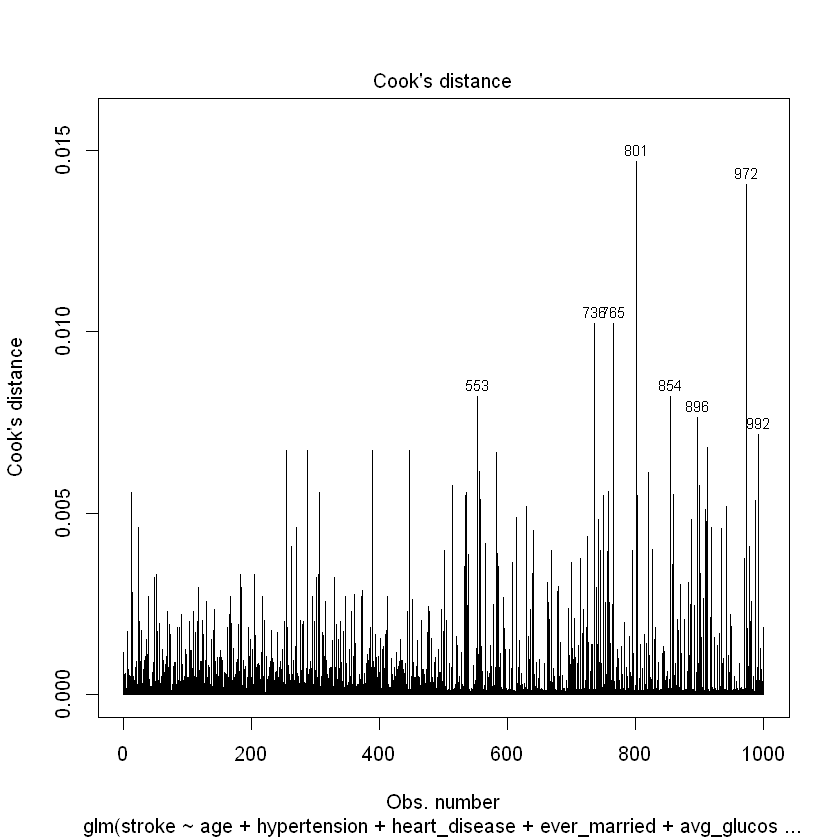

In [36]:

# Código
plot(stroke_balanceado_1, which = 4, id.n = 8)





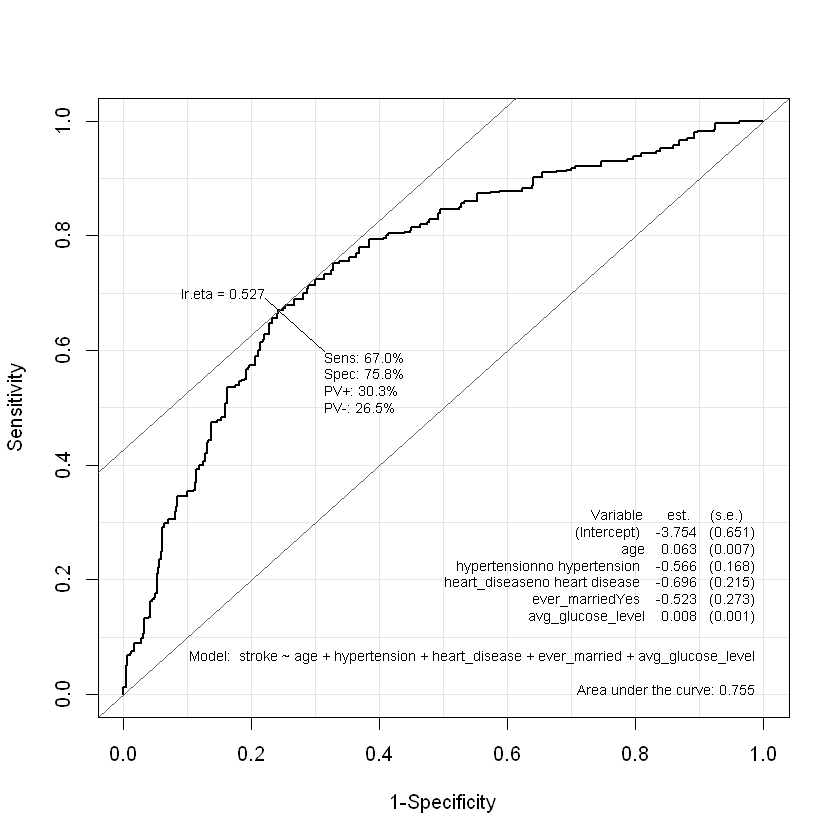

In [37]:
ROC( form=stroke~ age+hypertension+heart_disease+ever_married+avg_glucose_level,
data=newdata,plot="ROC")

In [38]:
exp(coef(stroke_balanceado_1))

(Intercept)                           age 
                   0.02342509                    1.06519451 
  hypertensionno hypertension heart_diseaseno heart disease 
                   0.56764412                    0.49833036 
              ever_marriedYes             avg_glucose_level 
                   0.59248245                    1.00798682

In [39]:
modelo_interaccion_Hiper_Casado <- glm(stroke~ age+hypertension*ever_married+avg_glucose_level+heart_disease,
data=newdata, family = binomial(link = "logit"))
summary(modelo_interaccion_Hiper_Casado)
exp(coef(modelo_interaccion_Hiper_Casado))  # Razones de ventajas ("odds ratios")


Call:
glm(formula = stroke ~ age + hypertension * ever_married + avg_glucose_level + 
    heart_disease, family = binomial(link = "logit"), data = newdata)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2839  -0.9585  -0.0909   0.9826   1.9206  

Coefficients:
                                             Estimate Std. Error z value
(Intercept)                                 -3.526631   0.720294  -4.896
age                                          0.063294   0.007389   8.566
hypertensionno hypertension                 -0.960342   0.545007  -1.762
ever_marriedYes                             -0.797253   0.458243  -1.740
avg_glucose_level                            0.007931   0.001245   6.369
heart_diseaseno heart disease               -0.688157   0.215761  -3.189
hypertensionno hypertension:ever_marriedYes  0.436524   0.572606   0.762
                                            Pr(>|z|)    
(Intercept)                                 9.78e-07 ***
age             

(Intercept) 
                                 0.02940382 
                                        age 
                                 1.06533986 
                hypertensionno hypertension 
                                 0.38276202 
                            ever_marriedYes 
                                 0.45056479 
                          avg_glucose_level 
                                 1.00796271 
              heart_diseaseno heart disease 
                                 0.50250133 
hypertensionno hypertension:ever_marriedYes 
                                 1.54731865

In [40]:
modelo_interaccion_Hiper_Glucosa <- glm(stroke~ age+hypertension*avg_glucose_level+heart_disease+ever_married,
data=newdata, family = binomial(link = "logit"))
summary(modelo_interaccion_Hiper_Glucosa)
exp(coef(modelo_interaccion_Hiper_Glucosa))  # Razones de ventajas ("odds ratios")


Call:
glm(formula = stroke ~ age + hypertension * avg_glucose_level + 
    heart_disease + ever_married, family = binomial(link = "logit"), 
    data = newdata)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.29612  -0.95836  -0.09172   0.97962   1.92593  

Coefficients:
                                                Estimate Std. Error z value
(Intercept)                                   -3.7388847  0.7072548  -5.286
age                                            0.0631418  0.0073874   8.547
hypertensionno hypertension                   -0.5859232  0.3986776  -1.470
avg_glucose_level                              0.0078440  0.0023919   3.279
heart_diseaseno heart disease                 -0.6957920  0.2158456  -3.224
ever_marriedYes                               -0.5233799  0.2731233  -1.916
hypertensionno hypertension:avg_glucose_level  0.0001517  0.0027895   0.054
                                              Pr(>|z|)    
(Intercept)                     

(Intercept) 
                                   0.02378061 
                                          age 
                                   1.06517791 
                  hypertensionno hypertension 
                                   0.55659179 
                            avg_glucose_level 
                                   1.00787484 
                heart_diseaseno heart disease 
                                   0.49867936 
                              ever_marriedYes 
                                   0.59251453 
hypertensionno hypertension:avg_glucose_level 
                                   1.00015169

In [41]:
modelo_interaccion_heart_casado <- glm(stroke~ age+hypertension+avg_glucose_level+heart_disease*ever_married,
data=newdata, family = binomial(link = "logit"))
summary(modelo_interaccion_heart_casado)
exp(coef(modelo_interaccion_heart_casado))  # Razones de ventajas ("odds ratios")


Call:
glm(formula = stroke ~ age + hypertension + avg_glucose_level + 
    heart_disease * ever_married, family = binomial(link = "logit"), 
    data = newdata)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.29100  -0.95979  -0.09771   0.98880   1.92301  

Coefficients:
                                               Estimate Std. Error z value
(Intercept)                                   -3.323181   1.206940  -2.753
age                                            0.063137   0.007380   8.556
hypertensionno hypertension                   -0.561705   0.168067  -3.342
avg_glucose_level                              0.007946   0.001246   6.378
heart_diseaseno heart disease                 -1.159974   1.102428  -1.052
ever_marriedYes                               -0.973614   1.089852  -0.893
heart_diseaseno heart disease:ever_marriedYes  0.484580   1.123336   0.431
                                              Pr(>|z|)    
(Intercept)                             

(Intercept) 
                                   0.03603803 
                                          age 
                                   1.06517246 
                  hypertensionno hypertension 
                                   0.57023610 
                            avg_glucose_level 
                                   1.00797796 
                heart_diseaseno heart disease 
                                   0.31349425 
                              ever_marriedYes 
                                   0.37771538 
heart_diseaseno heart disease:ever_marriedYes 
                                   1.62349347

In [42]:
prediccion_modelo=function(stroke_balanceado){
predicciones <- ifelse(test = stroke_balanceado$fitted.values > 0.5, yes = 1, no = 0)
matriz_confusion_balanceado <- table(stroke_balanceado$model$stroke, predicciones,
                          dnn = c("observaciones", "predicciones"))
nivel_b = (matriz_confusion_balanceado[1,1]+matriz_confusion_balanceado[2,2])/sum(matriz_confusion_balanceado)

matriz_confusion_balanceado
devianza=summary(stroke_balanceado)[[4]]
aic=summary(stroke_balanceado)[[5]]
tabla=cbind(matriz_confusion_balanceado,nivel_b,devianza,aic)
colnames(tabla)=c('0','1','Exactitud','Deviance','AIC')
return(tabla)
}

In [43]:
prediccion_modelo(stroke_balanceado_todo)
prediccion_modelo(stroke_balanceado_1)
prediccion_modelo(modelo_interaccion_Hiper_Casado)
prediccion_modelo(modelo_interaccion_Hiper_Glucosa)
prediccion_modelo(modelo_interaccion_heart_casado)

,0,1,Exactitud,Deviance,AIC
0,354,146,0.703,1174.608,1202.608
1,151,349,0.703,1174.608,1202.608


,0,1,Exactitud,Deviance,AIC
0,348,152,0.71,1184.876,1196.876
1,138,362,0.71,1184.876,1196.876


,0,1,Exactitud,Deviance,AIC
0,347,153,0.708,1184.283,1198.283
1,139,361,0.708,1184.283,1198.283


,0,1,Exactitud,Deviance,AIC
0,349,151,0.711,1184.873,1198.873
1,138,362,0.711,1184.873,1198.873


,0,1,Exactitud,Deviance,AIC
0,348,152,0.71,1184.671,1198.671
1,138,362,0.71,1184.671,1198.671


Analisis para los datos del ultimo modelo de muestras balanceadas

In [44]:
for (col_name in colnames(newdata[sapply(newdata, function(x) !(is.numeric(x)))])){
    output <- newdata %>%
        group_by(!!sym(col_name)) %>%
        summarise(n = n(),
            derrames = sum(stroke == 1)
        )
    View(output)
}

gender,n,derrames
<fct>,<int>,<int>
Female,586,276
Male,414,224


hypertension,n,derrames
<fct>,<int>,<int>
hypertension,243,157
no hypertension,757,343


heart_disease,n,derrames
<fct>,<int>,<int>
heart disease,144,105
no heart disease,856,395


ever_married,n,derrames
<fct>,<int>,<int>
No,77,47
Yes,923,453


work_type,n,derrames
<fct>,<int>,<int>
Govt_job,141,68
Private,586,293
Self-employed,273,139


Residence_type,n,derrames
<fct>,<int>,<int>
Rural,509,262
Urban,491,238


smoking_status,n,derrames
<fct>,<int>,<int>
formerly smoked,284,148
never smoked,408,200
smokes,150,82
Unknown,158,70


stroke,n,derrames
<fct>,<int>,<int>
0,500,0
1,500,500


stroke_t,n,derrames
<fct>,<int>,<int>
no stroke,500,0
stroke,500,500


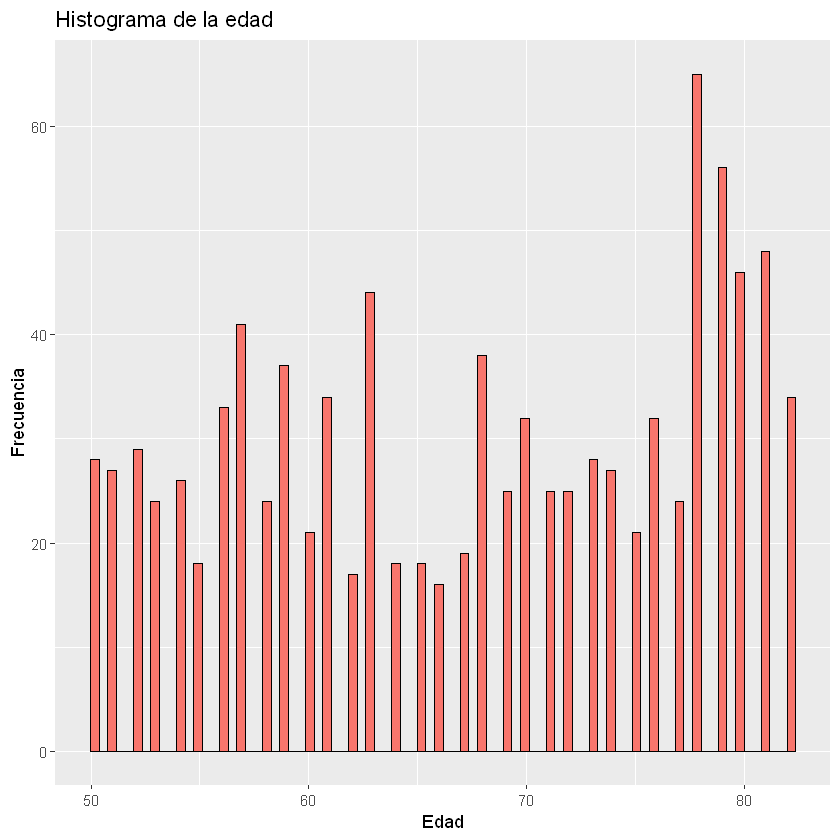

In [45]:
ggplot(newdata, aes(x = age)) + 
    geom_histogram(fill = '#F8766D', col = 'black',bins = max(data$age)) +   
labs(title = "Histograma de la edad",
       x="Edad",
       y="Frecuencia")

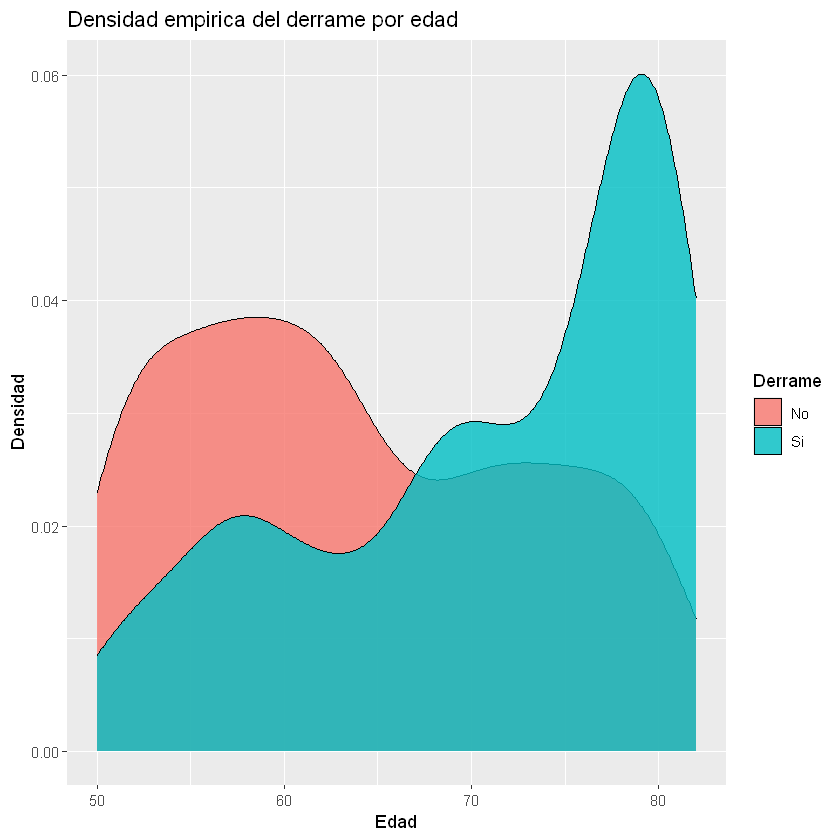

In [46]:
ggplot(newdata, aes(x = age, fill = stroke_t))+ geom_density(alpha = 0.8) + 
  labs(title = "Densidad empirica del derrame por edad",
       x="Edad",
       y="Densidad") + scale_fill_discrete(name = "Derrame", labels = c("No", "Si"))

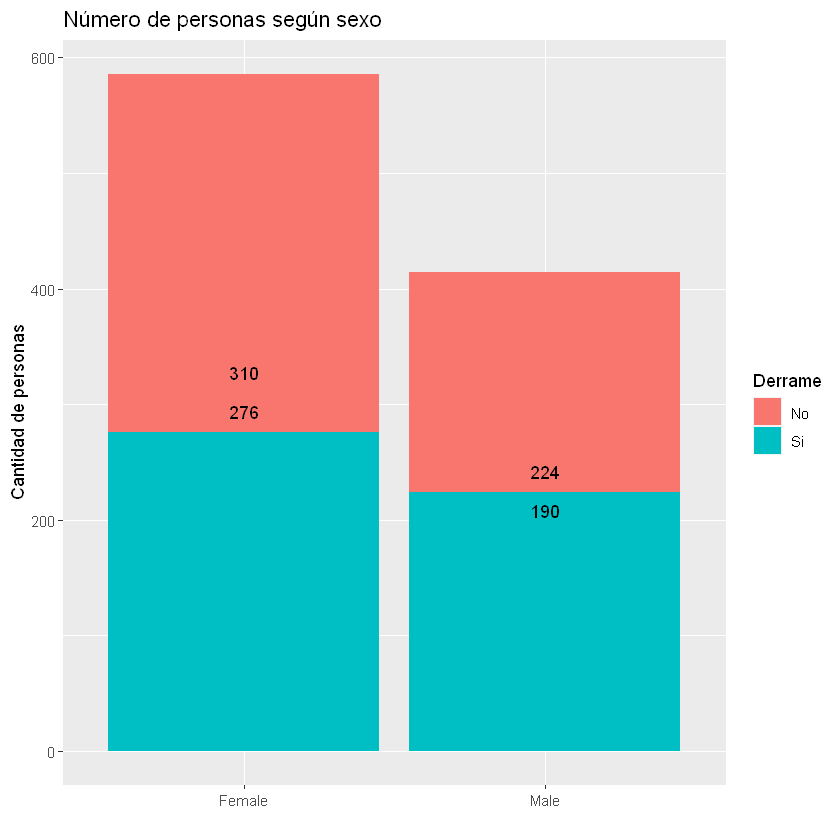

In [47]:
ggplot(data = newdata, aes(x=gender,fill=stroke))+geom_bar()+
  labs(title = "Número de personas según sexo",
       x="",
       y="Cantidad de personas") + scale_fill_discrete(name = "Derrame", labels = c("No", "Si")) + 
       geom_text(stat='count', aes(label=..count..), vjust=-1)

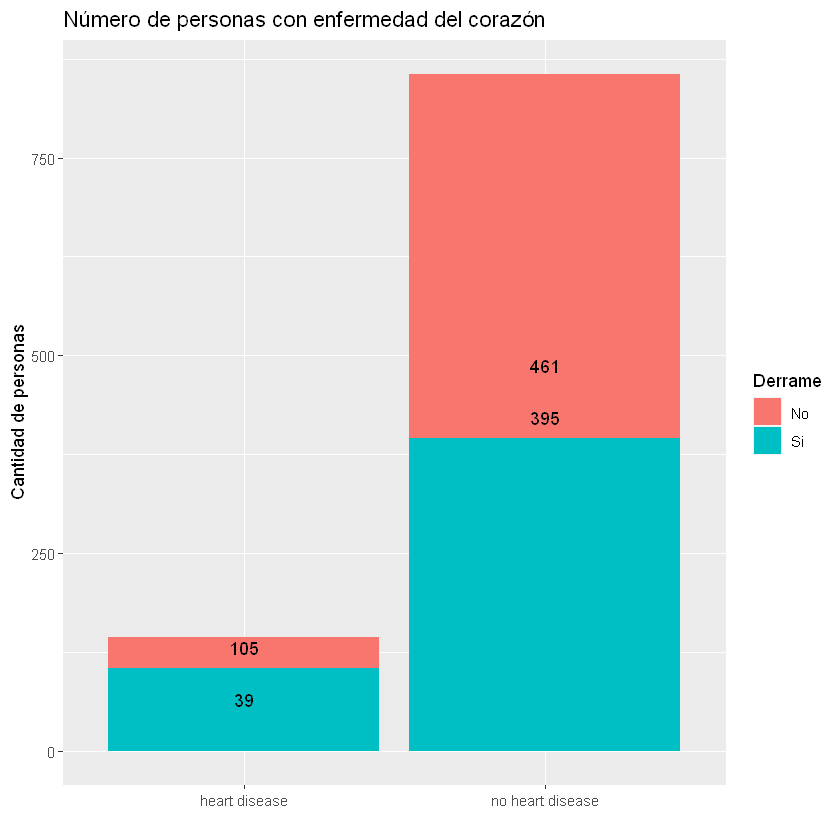

In [48]:
ggplot(data = newdata, aes(x=heart_disease,fill=stroke))+geom_bar()+
  labs(title = "Número de personas con enfermedad del corazón",
       x="",
       y="Cantidad de personas") + scale_fill_discrete(name = "Derrame", labels = c("No", "Si")) + 
       geom_text(stat='count', aes(label=..count..), vjust=-1)

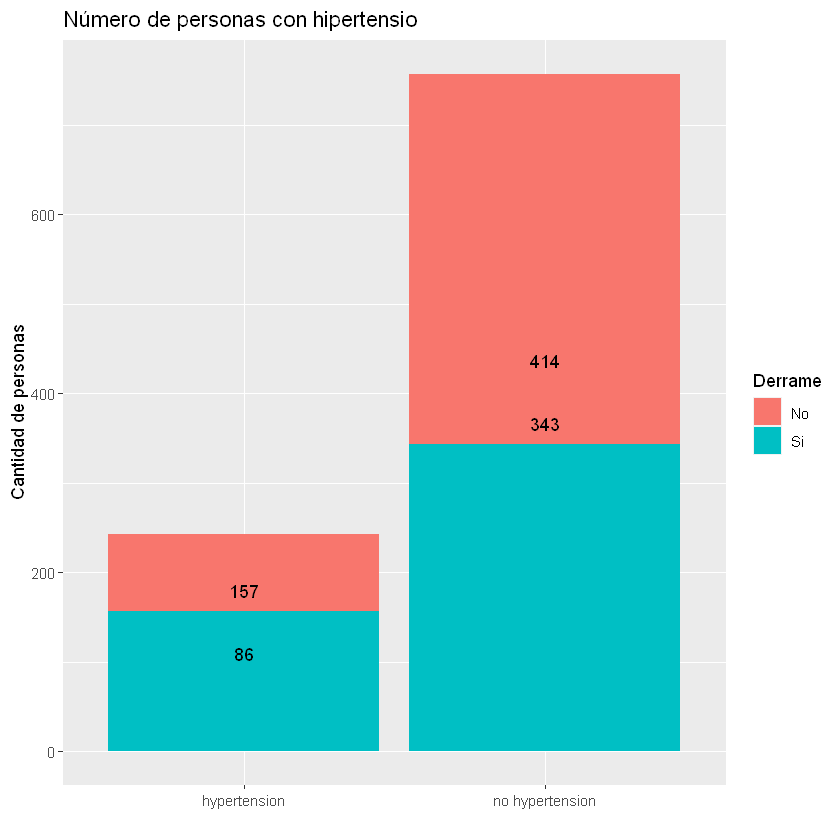

In [49]:
ggplot(data = newdata, aes(x=hypertension,fill=stroke))+geom_bar()+
  labs(title = "Número de personas con hipertensio",
       x="",
       y="Cantidad de personas") + scale_fill_discrete(name = "Derrame", labels = c("No", "Si")) + 
       geom_text(stat='count', aes(label=..count..), vjust=-1)

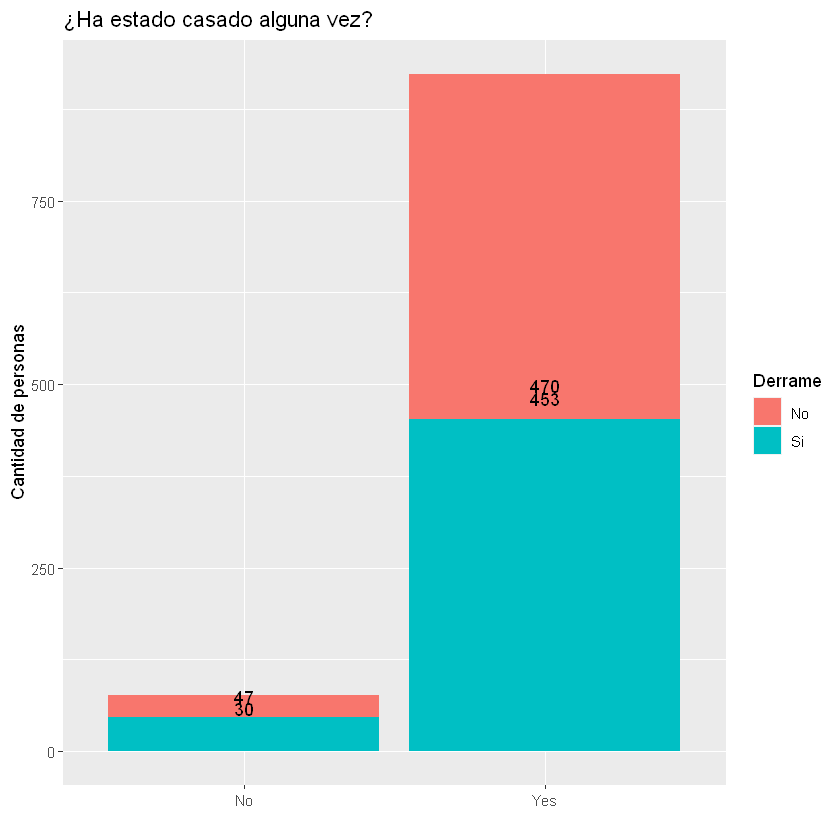

In [50]:
ggplot(data = newdata, aes(x=ever_married,fill=stroke))+geom_bar() + 
  labs(title = "¿Ha estado casado alguna vez?",
       x="",
       y="Cantidad de personas") + scale_fill_discrete(name = "Derrame", labels = c("No", "Si")) + 
       geom_text(stat='count', aes(label=..count..), vjust=-1)

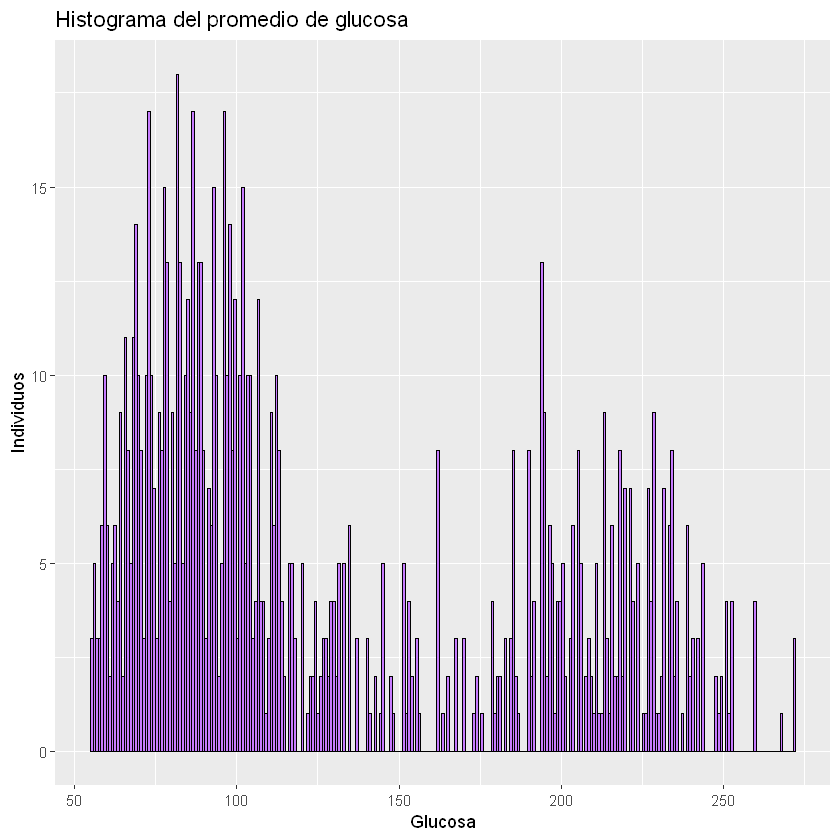

In [51]:
ggplot(newdata, aes(x = avg_glucose_level)) + geom_histogram(fill = '#C77CFF', col = 'black',bins = max(data$avg_glucose_level) ) +   
labs(title = "Histograma del promedio de glucosa",
       x="Glucosa",
       y="Individuos")

In [52]:
write.table(data,"Stroke_filtrado.txt",row.names = FALSE,col.names = TRUE,sep = ',')

In [53]:
delete<-c(254,288,389,447,553,736,765,801,972,992,912,854)

In [54]:
newdata1<-newdata
newdata1<-newdata[-delete,]
newdata1<-newdata1[-delete,]

In [55]:
stroke_balanceado_2 <- glm(stroke~ age+hypertension+heart_disease+ever_married+avg_glucose_level,
data=newdata1, family = binomial(link = "logit"))
summary(stroke_balanceado_2)


Call:
glm(formula = stroke ~ age + hypertension + heart_disease + ever_married + 
    avg_glucose_level, family = binomial(link = "logit"), data = newdata1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1698  -0.9235   0.2928   0.9424   1.9920  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -3.980534   0.677971  -5.871 4.33e-09 ***
age                            0.067704   0.007643   8.859  < 2e-16 ***
hypertensionno hypertension   -0.619899   0.173979  -3.563 0.000367 ***
heart_diseaseno heart disease -0.978546   0.232287  -4.213 2.52e-05 ***
ever_marriedYes               -0.438288   0.287595  -1.524 0.127515    
avg_glucose_level              0.009239   0.001303   7.088 1.36e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1354.4  on 976  degrees of freedom
Residual deviance: 1121.3  on

In [56]:
predicciones <- ifelse(test = stroke_balanceado_2$fitted.values > 0.5, yes = 1, no = 0)
matriz_confusion_balanceado <- table(stroke_balanceado_2$model$stroke, predicciones,
                          dnn = c("observaciones", "predicciones"))
matriz_confusion_balanceado

             predicciones
observaciones   0   1
            0 343 142
            1 136 356

In [69]:
(matriz_confusion_balanceado[1]+matriz_confusion_balanceado[4])/sum(matriz_confusion_balanceado)

[1] 0.7154555

In [57]:
exp(coef(stroke_balanceado_2))

(Intercept)                           age 
                   0.01867567                    1.07004857 
  hypertensionno hypertension heart_diseaseno heart disease 
                   0.53799855                    0.37585704 
              ever_marriedYes             avg_glucose_level 
                   0.64514024                    1.00928163

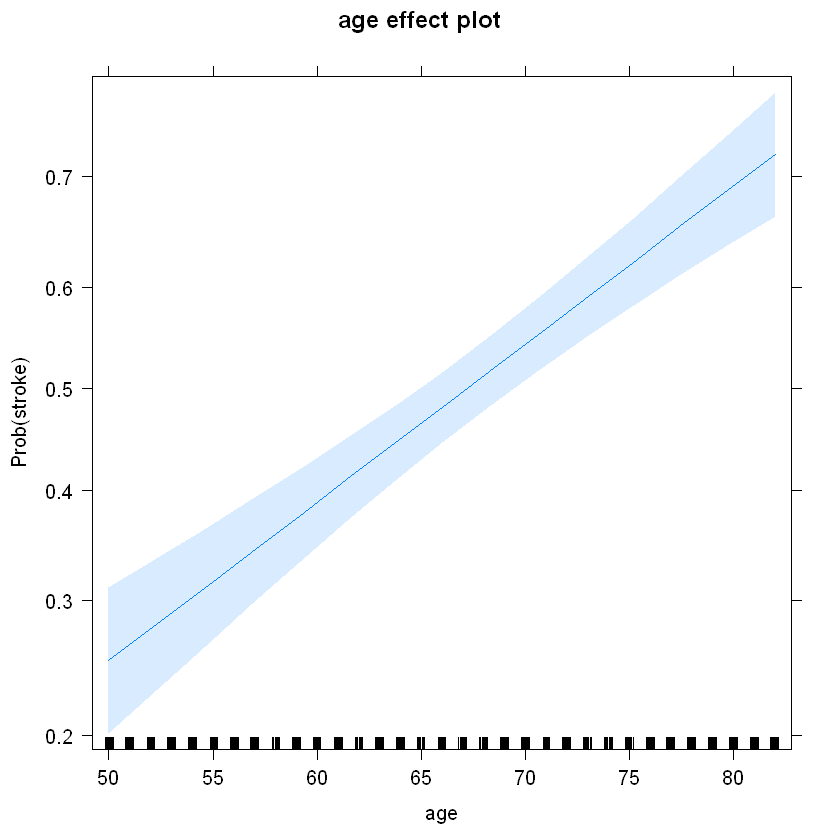

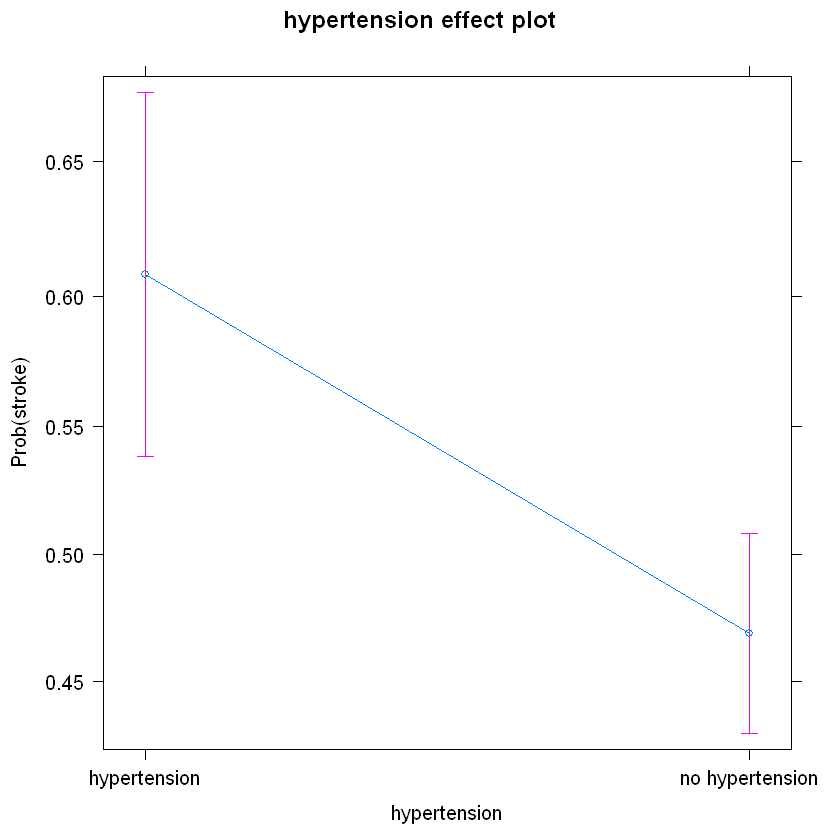

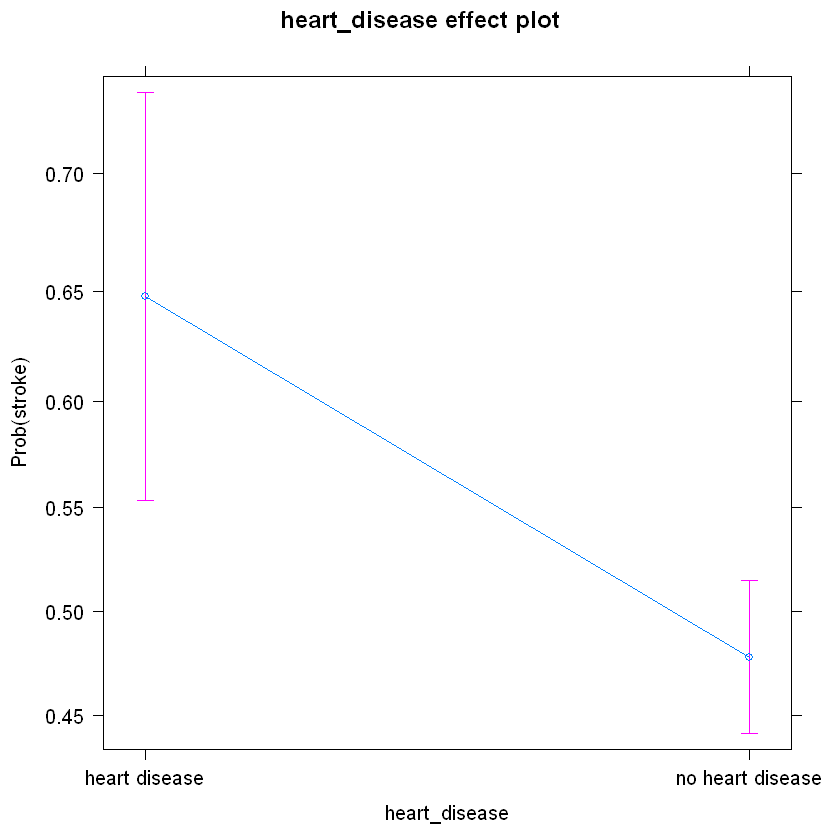

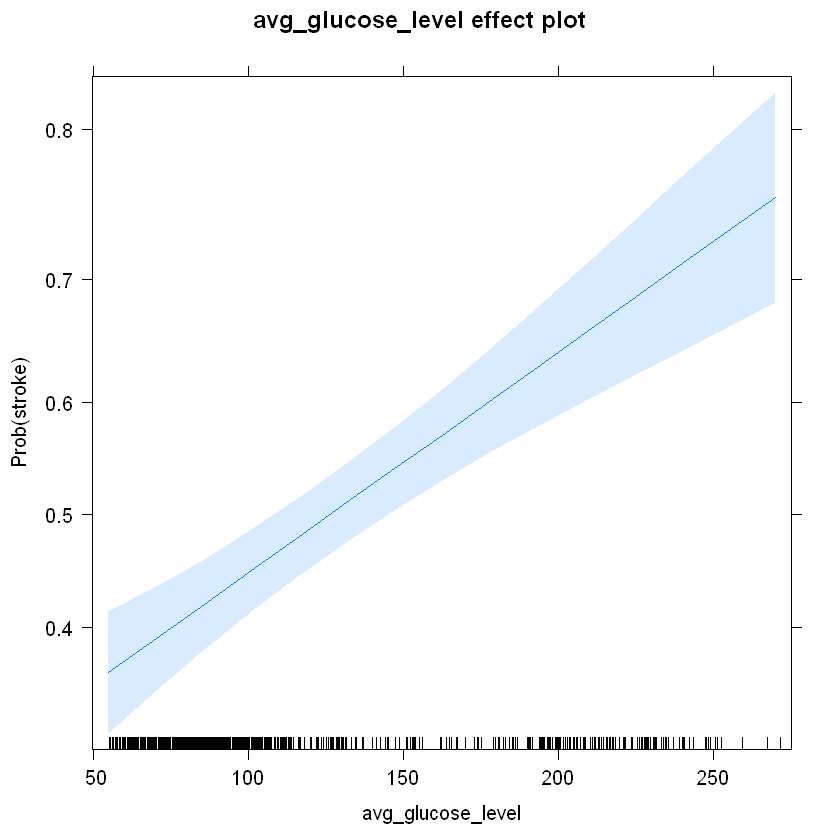

In [58]:
par(mfrow=c(2,2))
plot(effect("age",stroke_balanceado_1),ylab="Prob(stroke)")
plot(effect("hypertension",stroke_balanceado_1),ylab="Prob(stroke)")
plot(effect("heart_disease",stroke_balanceado_1),ylab="Prob(stroke)")
plot(effect("avg_glucose_level",stroke_balanceado_1),ylab="Prob(stroke)")


In [59]:
estadistico <- sum(residuals(stroke_balanceado_2,type="pearson")^2)
p <- 1 - pchisq(estadistico,1)
p

[1] 0

In [61]:
pR2 = 1 - stroke_balanceado_2$deviance / stroke_balanceado_2$null.deviance
pR2

[1] 0.1721005

In [63]:
confint(stroke_balanceado_2)



Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-5.320492914,-2.66023208
age,0.052880024,0.08286034
hypertensionno hypertension,-0.963392729,-0.28069175
heart_diseaseno heart disease,-1.446130288,-0.53300178
ever_marriedYes,-1.008280562,0.12252081
avg_glucose_level,0.006711155,0.01182545


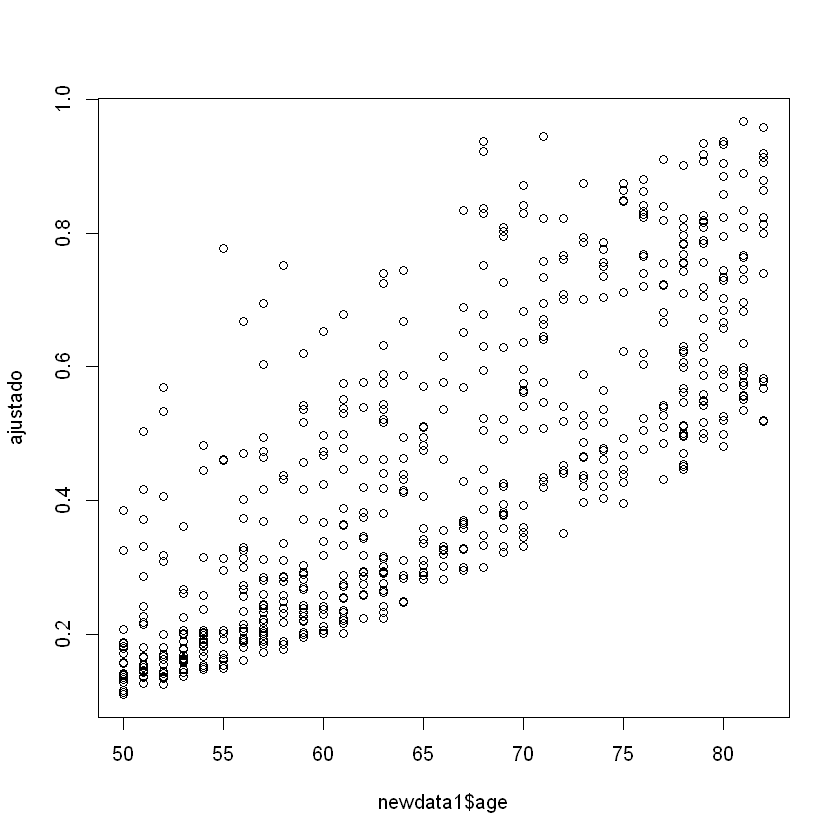

In [64]:
ajustado<-predict(stroke_balanceado_2,type="response")
plot(newdata1$age,ajustado)

In [ ]:

# Código
ROC( form=stroke~ age+hypertension+heart_disease+ever_married+avg_glucose_level,
data=newdata1,plot="ROC")


In [ ]:
modelo_1=gam(stroke~ age+hypertension+heart_disease+ever_married+avg_glucose_level,
data=newdata1,family=binomial,method="REML")
plot(modelo_1, all.terms = TRUE)

In [ ]:
plot(stroke_balanceado_2)